# Run Particle Thompson Sampling with Toy Data

Let's run the model with synthetic data and compare the cumulative regret of the model with the cumulative regret of random selection strategy.

In [1]:
import numpy as np
import logging
import itertools
from scipy.sparse import csr_matrix
import matplotlib
import matplotlib.pyplot as plt
import itertools
import time
import os
import pickle
import multiprocessing as mp
from collections import defaultdict

from almc.bayesian_rescal import gen_random_tensor
from almc.bayesian_rescal import PFBayesianRescal, compute_regret
from almc.bayesian_rescal.metrics import roc_auc_score, mean_squared_error

%matplotlib inline
# logger = logging.getLogger()
# logger.setLevel(logging.INFO)

## Generate Toy Dataset & RUN

In [11]:
n_test = 10

n_entities = [20]
n_relations = [10]
n_dim = 5
n_particle = 5

dest = '../result/toy2/'
for n_entity, n_relation in itertools.product(n_entities, n_relations):
    print(n_entity, n_relation)
    max_iter = n_relation * n_entity**2

    var_x = 0.01
    T = gen_random_tensor(n_dim, n_entity, n_relation, var_e=1, var_r=1, var_x=var_x)
    for nt in range(n_test):
        log_file = os.path.join(dest, '%d_%d_%d_%d.txt' % (n_entity,n_relation,n_dim,nt))
        if not os.path.exists(log_file):
            pickle.dump(T, open(os.path.join(dest,'%d_%d_%d_T.pkl' % (n_entity,n_relation,n_dim)), 'wb'))
            model = PFBayesianRescal(n_dim, var_x = var_x, n_particles=n_particle,
                                     compute_score=False, sample_prior=False, 
                                     gibbs_init=False, sample_all=True, log=log_file)
            seq = model.fit(T, obs_mask = np.zeros_like(T), max_iter=max_iter)

20 10


In [12]:
color = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),    
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),    
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),    
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),    
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]    
  
# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.    
for i in range(len(color)):    
    r, g, b = color[i]    
    color[i] = (r / 255., g / 255., b / 255.)

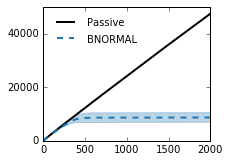

In [14]:
for n_entity, n_relation in itertools.product(n_entities, n_relations):
    max_iter = n_relation * n_entity**2
    regret = np.zeros([n_test, max_iter])
    random_regret = np.zeros(max_iter)
    T = pickle.load(open(os.path.join(dest, '%d_%d_%d_T.pkl' % (n_entity,n_relation,n_dim)), 'rb'))

    for nt in range(n_test):
        _seq = [s for s in itertools.product(range(n_relation), range(n_entity), range(n_entity))]
        np.random.shuffle(_seq)
        random_regret += np.cumsum(compute_regret(T, _seq))

        log_file = os.path.join(dest, '%d_%d_%d_%d.txt' % (n_entity,n_relation,n_dim,nt))
        seq = [line.strip().split(',') for line in open(log_file).readlines()]
        regret[nt] = np.cumsum(compute_regret(T, seq))

    plt.figure(figsize=(3,2.4))
    #plt.figure(figsize=(10,8))
    plt.plot(random_regret/n_test, label='Passive', linewidth=2, color='k')
    
    mean = np.mean(regret, 0)
    std = np.std(regret, 0)
    plt.plot(mean, '--', label='BNORMAL', linewidth=2, color=color[0])
    plt.fill_between(range(max_iter), mean-std, mean+std, alpha=0.3, color=color[0])

    plt.legend(loc='upper left', frameon=False)

    plt.setp(plt.gca().get_legend().get_texts(), fontsize='10')
#    plt.title('# entity = %d, # relation = %d' % (n_entity, n_relation))
    plt.xlim((0,2000))
    plt.ylim((0,50000))    
    plt.locator_params(axis = 'y', nbins = 4)
    plt.locator_params(axis = 'x', nbins = 5)
    plt.savefig('../paper/images/toy_%d_%d_%d.pdf' % (n_entity,n_relation,n_dim), format='PDF', bbox_inches='tight', pad_inches=0.1)    
    plt.show()

In [ ]:
# model parameters
n_test = 10

n_dim = 5
n_entities = 5
n_relations = 10

#for n_dim, n_entity, n_relation in itertools.product(n_dims, n_entities, n_relations):
    # additional parameters
max_iter = n_relation * n_entity**2
random_regret = np.zeros(max_iter)
result = list()

# dest
dest = '../result/toy2/'

if not os.path.exists(dest):
    os.makedirs(dest)

pool = mp.Pool(8)
tic=time.time()

T = np.zeros([n_test, n_relation, n_entity, n_entity])
for nt in range(n_test):
    # generate toy data
    var_e = 1.
    var_r = 1.
    var_x = 0.01
    test_file = os.path.join(dest, 'toy_data_%d_%d_%d_%d_%.2f_%.2f_%.2f.pkl' % (nt, n_dim, n_entity, n_relation, var_e, var_r, var_x))
    if os.path.exists(test_file):
        with open(test_file, 'rb') as f:
            _T = pickle.load(f)
            T[nt] = _T
    else:
        _T = gen_random_tensor(n_dim, n_entity, n_relation, var_e=var_e, var_r=var_r, var_x=var_x)
        T[nt] = _T
        with open(test_file, 'wb') as f:
            pickle.dump(_T, f)

    _var_x = var_x
    # particle thompson sampling
    for n_particle, rbp, var_x, mc_move in itertools.product(n_particles, rbps, var_xs, mc_moves):
        log_file = os.path.join(dest, 'pThompson_%d_%d_%d_%d_%.2f_%.2f_%.2f_%d_%r_%.2f_%d.txt' % (nt, n_dim, n_entity, n_relation, var_e, var_r, _var_x, n_particle, rbp, var_x, mc_move))
        if os.path.exists(log_file):
            continue

        def finalize(nt, n_particle, rbp, var_x, mc_move):
            # function argument closure
            def inner(rval):
                return result.append((rval, nt, n_particle, rbp, var_x, mc_move))
            return inner

        _callback = finalize(nt, n_particle, rbp, var_x, mc_move)

        print(log_file)
        maskT = np.zeros_like(T[nt])
        model = PFBayesianRescal(n_dim, var_x = var_x, n_particles=n_particle,
                                 compute_score=False, sample_prior=False, 
                                 gibbs_init=False, rbp=rbp, log=log_file)
        pool.apply_async(model.fit, args=(T[nt],), kwds={'obs_mask':maskT, 'max_iter':max_iter}, callback=_callback)

pool.close()
pool.join()
print('elapsed time', time.time()-tic)

In [ ]:
for nt, n_particle, rbp, var_x, mc_move in itertools.product(range(n_test), n_particles, rbps, var_xs, mc_moves):
    file = os.path.join(dest, 'pThompson_%d_%d_%d_%d_%.2f_%.2f_%.2f_%d_%r_%.2f_%d.txt' 
                        % (nt, n_dim, n_entity, n_relation, var_e, var_r, _var_x, n_particle, rbp, var_x, mc_move))
    seq = [line.split(',') for line in open(file, 'r').readlines()]    
    if (n_particle, rbp, var_x, mc_move) not in summary:
        summary[(n_particle, rbp, var_x, mc_move)] = np.zeros(max_iter)

    regret = compute_regret(T[nt], seq)
    summary[(n_particle, rbp, var_x, mc_move)] += np.cumsum(regret)


# compute cumulative regret of random selection
random_regret = np.zeros(max_iter)
for nt in range(n_test):
    _seq = [s for s in itertools.product(range(n_relation), range(n_entity), range(n_entity))]
    np.random.shuffle(_seq)
    regret = compute_regret(T[nt], _seq)
    random_regret += np.cumsum(regret)

# plot cumulative regrets
fig = plt.figure(figsize=(12,8))
plt.plot(range(max_iter), random_regret/n_test, label='RANDOM')

for key in summary.keys():
    n_particle, rbp, var_x, mc_move = key
    plt.plot(range(max_iter), summary[key]/n_test, label='pThompson-%d_%r_%.2f_%d' % (n_particle, rbp, var_x, mc_move))

plt.legend(loc=0)
plt.title('Cumulative Regret')
plt.show()

## Plot Cumulative Regret

### Compare Performance with Random Selection

In [ ]:
# compute cumulative regret for each configuration first
dest = '../result/toy2/'
#for seq, nt, n_particle, rbp, var_x, mc_move in result:
for n_dim, n_entity, n_relation in itertools.product(n_dims, n_entities, n_relations):
    summary = dict()    
    max_iter = n_relation * n_entity**2
    
    T = np.zeros([n_test, n_relation, n_entity, n_entity])
    for nt in range(n_test):
        test_file = os.path.join(dest, 'toy_data_%d_%d_%d_%d_%.2f_%.2f_%.2f.pkl' 
                                 % (nt, n_dim, n_entity, n_relation, var_e, var_r, var_x))        
        with open(test_file, 'rb') as f:
            _T = pickle.load(f)
            T[nt] = _T
                
    for nt, n_particle, rbp, var_x, mc_move in itertools.product(range(n_test), n_particles, rbps, var_xs, mc_moves):
        file = os.path.join(dest, 'pThompson_%d_%d_%d_%d_%.2f_%.2f_%.2f_%d_%r_%.2f_%d.txt' 
                            % (nt, n_dim, n_entity, n_relation, var_e, var_r, _var_x, n_particle, rbp, var_x, mc_move))
        seq = [line.split(',') for line in open(file, 'r').readlines()]    
        if (n_particle, rbp, var_x, mc_move) not in summary:
            summary[(n_particle, rbp, var_x, mc_move)] = np.zeros(max_iter)

        regret = compute_regret(T[nt], seq)
        summary[(n_particle, rbp, var_x, mc_move)] += np.cumsum(regret)


    # compute cumulative regret of random selection
    random_regret = np.zeros(max_iter)
    for nt in range(n_test):
        _seq = [s for s in itertools.product(range(n_relation), range(n_entity), range(n_entity))]
        np.random.shuffle(_seq)
        regret = compute_regret(T[nt], _seq)
        random_regret += np.cumsum(regret)

    # plot cumulative regrets
    fig = plt.figure(figsize=(12,8))
    plt.plot(range(max_iter), random_regret/n_test, label='RANDOM')

    for key in summary.keys():
        n_particle, rbp, var_x, mc_move = key
        plt.plot(range(max_iter), summary[key]/n_test, label='pThompson-%d_%r_%.2f_%d' % (n_particle, rbp, var_x, mc_move))

    plt.legend(loc=0)
    plt.title('Cumulative Regret')
    plt.show()

## Which configuration performs best?

In [ ]:
models = list()
for key in summary.keys():
    n_particle, rbp, var_x, mc_move = key
    final_regret = summary[key][-1]
    models.append((final_regret,'pThompson-%d_%r_%.2f_%d' % (n_particle, rbp, var_x, mc_move)))
models.sort()
for model in models:
    print(model)

## Cumulative Regret of First 200 Iterations

In [ ]:
# plot cumulative regrets
fig = plt.figure(figsize=(18,8))
print_iter = 200
for key in summary.keys():
    n_particle, rbp, var_x, mc_move = key
    if var_x == 0.1:
        plt.subplot(1,2,1)
        plt.plot(range(print_iter), summary[key][:print_iter]/n_test, label='pThompson-%d_%r_%.2f_%d' % (n_particle, rbp, var_x, mc_move))
    else:
        plt.subplot(1,2,2)
        plt.plot(range(print_iter), summary[key][:print_iter]/n_test, label='pThompson-%d_%r_%.2f_%d' % (n_particle, rbp, var_x, mc_move))

plt.subplot(1,2,1)
plt.legend(loc=0)
plt.title('Cumulative Regret, var_x = 0.1')
plt.subplot(1,2,2)
plt.legend(loc=0)
plt.title('Cumulative Regret, var_x = 0.01')
plt.show()

## Cumulative Regret of After 200 Iterations

In [ ]:
# plot cumulative regrets
fig = plt.figure(figsize=(18,8))
print_iter = 200
for key in summary.keys():
    n_particle, rbp, var_x, mc_move = key
    if var_x == 0.1:
        plt.subplot(1,2,1)
        plt.plot(range(max_iter-print_iter), summary[key][print_iter:]/n_test, label='pThompson-%d_%r_%.2f_%d' % (n_particle, rbp, var_x, mc_move))
    else:
        plt.subplot(1,2,2)
        plt.plot(range(max_iter-print_iter), summary[key][print_iter:]/n_test, label='pThompson-%d_%r_%.2f_%d' % (n_particle, rbp, var_x, mc_move))

plt.subplot(1,2,1)
plt.legend(loc=0)
plt.title('Cumulative Regret, var_x = 0.1')
plt.subplot(1,2,2)
plt.legend(loc=0)
plt.title('Cumulative Regret, var_x = 0.01')
plt.show()